# Tarea 30 de Octubre

In [15]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'y')

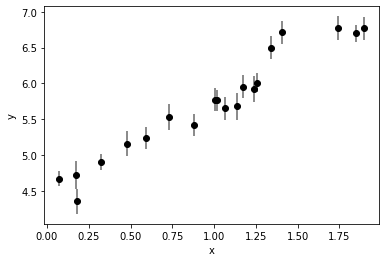

In [16]:
n = 20 # number of data points
m = 1.255 # randomly chosen truth
b = 4.507 

x = np.random.uniform(0, 2., n)
x.sort() # sort the values in place

# evaluate the true model at the given x values
y = m*x + b

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = np.random.uniform(0.1, 0.2, size=n) # randomly generate uncertainty for each datum
y = np.random.normal(y, y_err) # re-sample y data with noise

datastyle = dict(linestyle='none', marker='o', color='k', ecolor='#666666')
plt.errorbar(x, y, y_err,**datastyle)
plt.xlabel('x')
plt.ylabel('y')

In [17]:
#Definimos una función que evalue un modelo de linea recta en los valores x
# la variabele pars contiene los valores de los parametros m, b de la recta
def LineaRecta(pars, x):
    return pars[0]*np.array(x) + pars[1]

In [18]:
class ModeloLineaRecta(object):
    
    def __init__(self, x, y, y_err):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.y_err = np.asarray(y_err)

    def ln_likelihood(self, pars):
        N = len(self.y)
        
        #dy es la diferencia entre entre los datos exp. y los datos teóricos
        dy = self.y - LineaRecta(pars, self.x)
        # ivar es 1/varianza
        ivar = 1 / self.y_err**2 
        return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(self.y_err)) + np.sum(dy**2 * ivar))

    def ln_prior(self, pars):
        # el prior depende solo de los parámetros, en este caso tendremos un prior plano cuyos parámetros son la pendiente
        # y la ordenada al origen del modelo de la linea recta
        m, b = pars
        ln_prior_val = 0. 

        if m < 0 or m > 100.:
            return -np.inf
        else:
            0.0

        if m < -50 or m > 50.:
            return -np.inf
        else:
            0.0
        return 0.0
    

    def ln_posterior(self, pars):
        # el log del posterior es la suma del log prior más el log likelihood
        lnp = self.ln_prior(pars)        
        lnL = self.ln_likelihood(pars)
        lnprob = lnp + lnL

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

modelo = ModeloLineaRecta(x, y, y_err)

In [65]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

#definimos una función que genere samples de la funcion log-posterior partiendo los parametros iniciales.

def MCMC(p_init, N_iter, modelo, proposal_sigmas):
 
    #proposal_sigmas es una lista de desviaciones estandar pasadas a la funcion sample_proposal
    
    #p_init contiene inf. sobre los parametros iniciales m, b
    p_init = np.array(p_init)
    
    #N_iter es el numero de iteraciones 
    # chain es un objeto que será llenado con los valores de los parametros en cada iteracion
    chain = np.zeros((N_iter, len(p_init)))
    # ln_probs es un objeto que será llenado con los valores de log-probability en cada iteración
    ln_probs = np.zeros(N_iter) 
    
    # esta variable sirve para calcular la fraccion de aceptación
    n_accept = 0 
    
    # aquí evaluamos el log del posterior en el punto inicial y almacenamos ese valor en el elemento 0 de chain
    ln_probs[0] = modelo(p_init)
    chain[0] = p_init
    
    # loop sobre el número de iteraciones 
    for i in range(1,N_iter):
        # proponemos un nuevo punto aleatorio
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        # compute log-posterior at new parameter values
        new_ln_prob = modelo(new_p)
        
        # log of the ratio of the new log-posterior to the previous log-posterior value
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform(0,1))):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
            
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / N_iter
    print("El nuevo punto es: ",new_p)
    
    return chain, ln_probs, acc_frac

print('La pendiente, m, es: ',m)
print('La ordenada al origen, b, es: ',b)

La pendiente, m, es:  1.255
La ordenada al origen, b, es:  4.507


In [20]:
p_init = [6.,6.]
chain,_,acc_frac = MCMC(p_init, N_iter=10000, modelo=modelo, proposal_sigmas=[0.05,0.05])
print("Acceptance fraction: {:.1%}".format(acc_frac))

El nuevo punto es:  [1.13792488 4.52033324]
Acceptance fraction: 43.3%


Text(0, 0.5, '$b$')

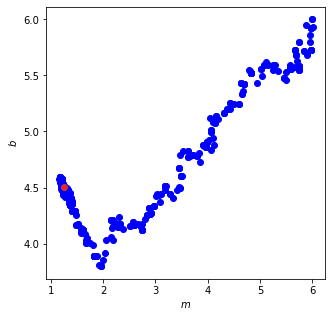

In [21]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(m, b, marker='o', zorder=10, color='#de2d26')
#ax.plot(chain[:512,0], chain[:512,1], marker='', color='k', linewidth=1.)

plt.scatter(chain[:400,0], chain[:400,1], c='b')
ax.set_xlabel('$m$')
ax.set_ylabel('$b$')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


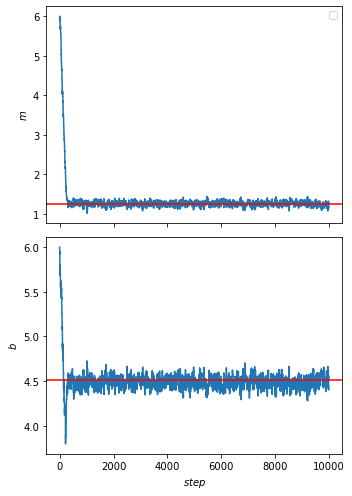

In [33]:
# Grafiquemos los parámetros en cada 'step'

fig,axes = plt.subplots(len(p_init), 1, figsize=(5,7), sharex=True)
for i in range(len(p_init)):
    axes[i].plot(chain[:,i], marker='', drawstyle='steps')
    
axes[0].axhline(m, color='r', label='')
axes[0].legend(loc='best')
axes[0].set_ylabel('$m$')
#axes[0].set_xlabel('$step$')

axes[0].legend(loc='best')
axes[1].axhline(b, color='r')
axes[1].set_ylabel('$b$')
axes[1].set_xlabel('$step$')

fig.tight_layout()



In [59]:
# podemos ver que después de unos cientos de iteraciones la cadena converge, para la iter. 1000 es evidente que converge
# a partir de la iter. 1000 hasta la 10000 brincaremos en steps de 8 en 8
good_samples = chain[1000::8]
good_samples.shape

(1125, 2)

In [63]:
# nos quedamos con 1125 samples
# vamos a reportar la mediana y los percentiles 15 y 85
from IPython import display

low,med,hi = np.percentile(good_samples, [15, 50, 85], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['m', 'b']):
    fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

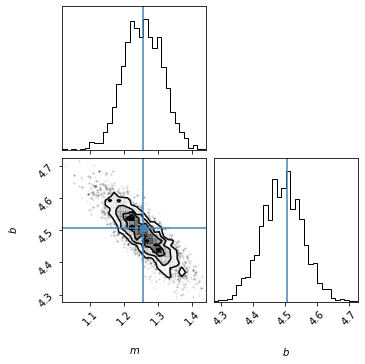

In [43]:
import corner
fig = corner.corner(chain[1000:], bins=32, labels=['$m$', '$b$'], truths=[m, b])